## Fetch technical functions

In [1]:
# Get the technical functions
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/embedder.tp
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/generator.py
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/discriminator.py

--2020-01-24 10:33:18--  https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/calogan_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4115 (4.0K) [text/plain]
Saving to: ‘calogan_metrics.py’

calogan_metrics.py  100%[===================>]   4.02K  --.-KB/s    in 0s      

2020-01-24 10:33:18 (95.8 MB/s) - ‘calogan_metrics.py’ saved [4115/4115]

--2020-01-24 10:33:23--  https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/prd_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

Available device = cuda


## Fetch the dataset

In [3]:
from google.colab import drive
drive.mount('/gdrive')

# Uncomment if running via google colab
# (you might need to change the paths in this case)
def_colab_path = '/gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/'
train_data_path = def_colab_path + 'data/data_train.npz'
val_data_path   = def_colab_path + 'data/data_val.npz'
test_data_path  = def_colab_path + 'data/data_test.npz'

# Uncomment if running locally
#train_data_path = '../data_train.npz'
#val_data_path   = '../data_val.npz'
#test_data_path  = '../data_test.npz'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Load the data

In [0]:
def dataset_rotations_transform(EnergyDeposit, ParticleMomentum, ParticlePoint, PDG):
    """
    Rotate calorimeter energy deposit by 0,90,180,270 degrees, effectively makes
    the dataset 4 times larger.
    
    Rotation of momentum and coord by 90 deg (direction is from x towards y axis)
    (p_x, p_y, p_z) -> (-p_y, p_x, p_z)
    (x, y) -> (-y, x)

        Parameters
        ----------
            EnergyDeposit : torch.Tensor
                Array of energy deposits.
            
            ParticleMomentum : torch.Tensor
                Array of particle momentum.
            
            ParticlePoint : torch.Tensor
                Array of particle coordinates.
            
            PDG : torch.Tensor
                Array of particle types.
            
        Returns:
        ----------
            EnergyDeposit, Momentum, Point, PDG : torch.Tensor x4
                Transformed energy distribution, momentum, coordinate and 
                particle type arrays.
    """
    N = len(PDG)
    transf_energy   = np.zeros((4, N, 1, 30, 30))
    transf_momentum = np.zeros((4, N, 3))
    transf_point    = np.zeros((4, N, 2))
    transf_pdg      = np.zeros((4, N, 1))

    for i in range(0,N):
        transf_energy  [0][i] = EnergyDeposit   [i]
        transf_momentum[0][i] = ParticleMomentum[i]
        transf_point   [0][i] = ParticlePoint   [i]
        transf_pdg     [0][i] = PDG             [i]

        for rotation_num in range(1,4):
            transf_energy  [rotation_num][i] = np.rot90(transf_energy[rotation_num - 1][i], axes=(1,2))
            
            transf_momentum[rotation_num][i][0] = -transf_momentum[rotation_num - 1][i][1] # p_x -> -p_y
            transf_momentum[rotation_num][i][1] = +transf_momentum[rotation_num - 1][i][0] # p_y -> p_x
            transf_momentum[rotation_num][i][2] = +transf_momentum[rotation_num - 1][i][2] # p_z -> p_z
            
            transf_point   [rotation_num][i][0] = -transf_momentum[rotation_num - 1][i][1] # x -> -y
            transf_point   [rotation_num][i][1] = +transf_momentum[rotation_num - 1][i][0] # y -> x

            transf_pdg[rotation_num][i] = PDG[i]

    transf_energy   = torch.tensor(np.concatenate(transf_energy,   axis=0)).float()
    transf_momentum = torch.tensor(np.concatenate(transf_momentum, axis=0)).float()
    transf_point    = torch.tensor(np.concatenate(transf_point,    axis=0)).float()
    transf_pdg      = torch.tensor(np.concatenate(transf_pdg,      axis=0)).float()
    return transf_energy, transf_momentum, transf_point, transf_pdg


def dataset_one_particle_type_transform(type_id, EnergyDeposit, ParticleMomentum, ParticlePoint, PDG):
    """
        Select only samples of a particular particle type from data arrays.

        Parameters
        ----------
            type_id : float
                ID of the particle type to be selected.

            EnergyDeposit : torch.Tensor
                Array of energy deposits.
            
            ParticleMomentum : torch.Tensor
                Array of particle momentum.
            
            ParticlePoint : torch.Tensor
                Array of particle coordinates.
            
            PDG : torch.Tensor
                Array of particle types.
            
        Returns:
        ----------
            EnergyDeposit, Momentum, Point, PDG : torch.Tensor x4
                Transformed energy distribution, momentum, coordinate and 
                particle type arrays.
    """
    ind = [i for i, x in enumerate(PDG) if x == type_id]
    return EnergyDeposit[ind], ParticleMomentum[ind], ParticlePoint[ind], PDG[ind]

def get_data_by_indexes(data_arr, ind_arr):
    """
        Select data samples specified by an index array.

        Parameters
        ----------
            data_arr : dict
                The data array (dictionary).
            
            ind_arr : np.array
                The index array.
            
        Returns:
        ----------
            energy, momentum, point, pdg : torch.Tensor x4
                Arrays of data samples that were specified by an index array.
    """
    # [data_size, 900]
    # reshaping it as [data_size, channels, img_size_x, img_size_y]
    energy   = torch.tensor(data_arr['EnergyDeposit'][ind_arr].reshape(-1, 1, 30, 30)).float()
    momentum = torch.tensor(data_arr['ParticleMomentum'][ind_arr]).float()
    point    = torch.tensor(data_arr['ParticlePoint'][:, :2][ind_arr]).float()
    pdg      = torch.tensor(data_arr['ParticlePDG'][ind_arr]).float()
    return energy, momentum, point, pdg


def get_dataset(data_arr, size, rotate_transf=False, one_particle_transf=True, particle_id=11.):
    """
        Create a tensor dataset of the specified size and apply transformations.

        Parameters
        ----------
            data_arr : dict
                The data array (dictionary).
            
            size : int
                Size of the initial (before transformations) dataset.

            rotate_transf : bool
                Flag specifying if the rotations transformation should be applied.

            one_particle_transf : bool 
                Flag specifying if the one particle type selection transformation should be applied.

            particle_id : int
                ID of the particle to be used for one particle type selection transformation.
            
        Returns:
        ----------
            dataset : utils.TensorDataset
                The created dataset.
    """
    ind_arr = np.random.choice(len(data_arr['ParticlePDG']), size, replace=False)

    energy, momentum, point, pdg = get_data_by_indexes(data_arr, ind_arr)

    if one_particle_transf:
        energy, momentum, point, pdg = dataset_one_particle_type_transform(particle_id, energy, momentum, point, pdg)
    if rotate_transf:
        energy, momentum, point, pdg = dataset_rotations_transform(energy, momentum, point, pdg)

    return utils.TensorDataset(energy, momentum, point, pdg)

In [0]:
data_train = np.load(train_data_path, allow_pickle=True)

In [7]:
# Normalising stuff

type_id = 11.

ind = [i for i, x in enumerate(data_train['ParticlePDG']) if x == type_id]

mean_train_mom   = np.mean(data_train['ParticleMomentum'][ind], axis=0)
mean_train_point = np.mean(data_train['ParticlePoint'][:,:2][ind], axis=0)

std_train_mom   = np.std(data_train['ParticleMomentum'][ind], axis=0)
std_train_point = np.std(data_train['ParticlePoint'][:,:2][ind], axis=0)

print(mean_train_mom, mean_train_point)
print(std_train_mom, std_train_point)

MEAN_TRAIN_MOM   = np.array([-0.08164814, -0.02489864, 20.8446184])
MEAN_TRAIN_POINT = np.array([-0.01204223,  0.02772552])
STD_TRAIN_MOM    = np.array([ 5.4557047,   5.38253167, 24.26102735])
STD_TRAIN_POINT  = np.array([ 2.69435522,  2.65776869])

[-0.08164814 -0.02489864 20.8446184 ] [-0.01204223  0.02772552]
[ 5.4557047   5.38253167 24.26102735] [2.69435522 2.65776869]


In [8]:
mean_train_energy_pix = np.mean(data_train['EnergyDeposit'][ind])
std_train_energy_pix = np.std(data_train['EnergyDeposit'][ind])

print(mean_train_energy_pix, std_train_energy_pix)

MEAN_TRAIN_ENERGY_PIX = 3.870147771370233
STD_TRAIN_ENERGY_PIX = 25.186363383917545

3.870147771370233 25.186363383917545


## Training GAN
###### ...is not a simple matter
###### so here is some [music for this long process](https://www.youtube.com/watch?v=rdU-BrNTgjg)

In [0]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN', 'HINGE']

TASK = 'HINGE'

# Additional things for Wasserstein GAN
LIPSITZ_WEIGHTS = False
clamp_lower, clamp_upper = -0.01, 0.01

GRAD_PENALTY = True                # https://arxiv.org/abs/1704.00028
ZERO_CENTERED_GRAD_PENALTY = False   # https://arxiv.org/abs/1705.09367

# Small hack that can speed-up training and improve generalization
INSTANCE_NOISE = True                # https://arxiv.org/abs/1610.04490

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

def l2_norm(tensor):
    """Return the l2 norm of a tensor."""
    return torch.sqrt(1e-8 + torch.sum(tensor**2))

In [0]:
class GANLosses(object):
    def __init__(self, task, device, gp = 'local-two-sided'):
        self.TASK = task
        self.device = device
        self.GP = gp
    
    def g_loss(self, discrim_output):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output + eps).mean()
        elif self.TASK in ['WASSERSTEIN', 'HINGE']:
            loss = - discrim_output.mean()
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        elif self.TASK == 'HINGE':
            loss = torch.nn.ReLU()(1.0 - discrim_output_real).mean() + torch.nn.ReLU()(1.0 + discrim_output_gen).mean()
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = .1):
        gradient_penalty = 0
        k = 1

        if self.GP == 'local-two-sided':
            N = 10

            noise_y = torch.normal(0, N, size=inp_data.shape).to(self.device)

            perturbed_y = (inp_data + noise_y).to(self.device)

            perturbed_y.requires_grad = True

            disc_interpolates = discriminator(perturbed_y, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=perturbed_y,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((l2_norm(gradients) - k) ** 2).mean() * lambda_reg

        elif self.GP == 'original':
            alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
            dims_to_add = len(inp_data.size()) - 2
            for i in range(dims_to_add):
                alpha = alpha.unsqueeze(-1)
                # alpha = alpha.expand(inp_data.size())

            interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

            interpolates.requires_grad = True

            disc_interpolates = discriminator(interpolates, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg

        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

## Defining generator and discriminator

In [0]:
MEAN_TRAIN_MOM   = np.array([-0.08164814, -0.02489864, 20.8446184])
MEAN_TRAIN_POINT = np.array([-0.01204223,  0.02772552])
STD_TRAIN_MOM    = np.array([ 5.4557047,   5.38253167, 24.26102735])
STD_TRAIN_POINT  = np.array([ 2.69435522,  2.65776869])

MEAN_TRAIN_MOM_POINT = torch.Tensor([-0.08164814, -0.02489864, 20.8446184, -0.01204223,  0.02772552]).to(device)
STD_TRAIN_MOM_POINT  = torch.Tensor([ 5.4557047,   5.38253167, 24.26102735, 2.69435522,  2.65776869]).to(device)

MEAN_TRAIN_ENERGY_PIX = 3.870147771370233
STD_TRAIN_ENERGY_PIX  = 25.186363383917545

MEAN_TRAIN_ENERGY_DIST = torch.full((1,30,30), 3.870147771370233).to(device)
STD_TRAIN_ENERGY_DIST  = torch.full((1,30,30), 25.186363383917545).to(device)

In [0]:
# тут неплохое объяснение, если перевести)) https://zhuanlan.zhihu.com/p/61248211, 
# + https:/github.com/pytorch/pytorch/issues/8985#issuecomment-405080775

class ConditionalBatchNorm2d(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.num_features = out_features
    self.bn = nn.BatchNorm2d(out_features, affine=False)
    self.gammas = nn.Linear(in_features, out_features)
    self.bethas = nn.Linear(in_features, out_features)
    self._initialize()

  def _initialize(self):
    nn.init.ones_(self.gammas.weight.data)
    nn.init.zeros_(self.bethas.weight.data)

  def forward(self, x, y):
    batchnorm = self.bn(x)
    gamma = self.gammas(y)
    beta = self.bethas(y)
    out = (gamma.view(-1, self.num_features, 1, 1)) * batchnorm + beta.view(-1, self.num_features, 1, 1)
    return out

In [0]:
# https://pytorch.org/docs/stable/nn.html#layernorm

NUM_DIS_FEAT = 16

# spectral norm: https://arxiv.org/pdf/1802.05957.pdf
from torch.nn.utils import spectral_norm

class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        
        # 30x30x1
        self.conv1 = spectral_norm(nn.Conv2d( 1,   32, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x32
        #self.ln1   = nn.LayerNorm([32, 30, 30])
        self.conv2 = spectral_norm(nn.Conv2d( 32,  64, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x64
        #self.ln2   = nn.LayerNorm([64, 30, 30])        
        self.pool1 = nn.MaxPool2d(2, 2)                                                  # 15x15x64

        self.conv3 = spectral_norm(nn.Conv2d( 64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x128
        #self.ln3   = nn.LayerNorm([128, 15, 15])
        self.conv4 = spectral_norm(nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x256
        #self.ln4   = nn.LayerNorm([256, 15, 15])
        self.pool2 = nn.MaxPool2d(3, 3)                                                  # 15x15x256
        
        # 5x5x256 = 6400
        self.fc1 = spectral_norm(nn.Linear(6400 + 5, 1))
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = EnergyDeposit
        X = F.leaky_relu(self.conv1(X))
        X = F.leaky_relu(self.conv2(X))
        X = self.pool1(X)

        X = F.leaky_relu(self.conv3(X))
        X = F.leaky_relu(self.conv4(X))
        X = self.pool2(X)
        
        X = X.view(len(X), -1)
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        X = torch.cat([X, mom_point], dim=1)
        
        #X = F.leaky_relu(self.fcbn1(self.fc1(X)))
        #X = F.leaky_relu(self.fcbn2(self.fc2(X)))
        #X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK in ['WASSERSTEIN', 'HINGE']:
            return self.fc1(X)
        else:
            return torch.sigmoid(self.fc1(X))

In [0]:
from generator import NOISE_DIM

# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 20736)

        self.conv1 = spectral_norm(nn.ConvTranspose2d(256, 256, 3, stride=2, output_padding=1))
        #self.bn1 = ConditionalBatchNorm2d(5, 256)
        self.bn1 = nn.BatchNorm2d(256)
        #self.ln1 = nn.LayerNorm([256, 20, 20])
        self.conv2 = spectral_norm(nn.ConvTranspose2d(256, 128, 3))
        #self.bn2 = ConditionalBatchNorm2d(5, 128)
        self.bn2 = nn.BatchNorm2d(128)
        #self.ln2 = nn.LayerNorm([128, 22, 22])
        self.conv3 = spectral_norm(nn.ConvTranspose2d(128, 64, 3))
        #self.bn3 = ConditionalBatchNorm2d(5, 64)
        self.bn3 = nn.BatchNorm2d(64)
        #self.ln3 = nn.LayerNorm([64, 24, 24])
        self.conv4 = spectral_norm(nn.ConvTranspose2d(64, 32, 3))
        #self.bn4 = ConditionalBatchNorm2d(5, 32)
        self.bn4 = nn.BatchNorm2d(32)
        #self.ln4 = nn.LayerNorm([32, 26, 26])
        self.conv5 = spectral_norm(nn.ConvTranspose2d(32, 16, 3))
        self.bn5 = nn.BatchNorm2d(16)
        #self.ln5 = nn.LayerNorm([16, 28, 28])
        self.conv6 = spectral_norm(nn.ConvTranspose2d(16, 1, 3))
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #mom_point = ParticleMomentum_ParticlePoint
        x = torch.cat([z, mom_point], dim=1)
        x = F.leaky_relu(self.fc1(z))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        EnergyDeposit = x.view(-1, 256, 9, 9)
        
        #print(EnergyDeposit.shape)
        #EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit), mom_point))
        #EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit), mom_point))
        #EnergyDeposit = F.leaky_relu(self.bn4(self.conv4(EnergyDeposit), mom_point))
        EnergyDeposit = F.leaky_relu(self.bn1(self.conv1(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn4(self.conv4(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn5(self.conv5(EnergyDeposit)))
        EnergyDeposit = self.conv6(EnergyDeposit)

        return EnergyDeposit

## Check models on one batch 

In [0]:
def check_models():
    # size of the train dataset
    # (change to a lower value if you require a subset)
    # (dataset transformations like rotations will change the specified value!)
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    TRAIN_SIZE = 4000 * 2
    VALID_RAT  = 0.1
    VALID_SIZE = int(VALID_RAT * TRAIN_SIZE)

    train_dataset = get_dataset(data_train, TRAIN_SIZE, one_particle_transf=True, particle_id=11.) # without replacement
    valid_dataset = get_dataset(data_train, VALID_SIZE, one_particle_transf=True, particle_id=11.)

    TRAIN_SIZE, VALID_SIZE = len(train_dataset), len(valid_dataset)
    BATCH_SIZE = 512

    calo_dataloader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                    pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                                    pin_memory=True, shuffle=False)

    #print('Max train dataset size', MAX_TRAIN_SIZE)
    #print("Training dataset size =", TRAIN_SIZE)
    #print("Validation dataset size =", VALID_SIZE)
    #print(list(data_train.keys()))

    discriminator = ModelD().to(device)
    generator = ModelGConvTranspose(z_dim=NOISE_DIM).to(device)


    for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, PDG_b in calo_dataloader:
        break

    EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                        ParticleMomentum_b.to(device), \
                                                        ParticlePoint_b.to(device)
    ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

    print(EnergyDeposit_b.shape)
    print(ParticleMomentum_ParticlePoint_b.shape)
    print(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape)
    noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
    print(generator(noise, ParticleMomentum_ParticlePoint_b).shape)
    print(noise[0])
    print(ParticleMomentum_ParticlePoint_b[0])
    print(torch.cat([noise, ParticleMomentum_ParticlePoint_b], dim=1)[0])

In [18]:
check_models()

torch.Size([512, 1, 30, 30])
torch.Size([512, 5])
torch.Size([512, 1])
torch.Size([512, 1, 30, 30])
tensor([-2.4862,  0.9261, -1.1612, -0.3276, -1.5623,  0.1093, -0.1577, -0.1048,
         0.8380,  0.6701], device='cuda:0')
tensor([-26.1329,   4.4515,  71.1023,   6.4558,  -0.5187], device='cuda:0')
tensor([ -2.4862,   0.9261,  -1.1612,  -0.3276,  -1.5623,   0.1093,  -0.1577,
         -0.1048,   0.8380,   0.6701, -26.1329,   4.4515,  71.1023,   6.4558,
         -0.5187], device='cuda:0')


## Plot functions

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tck

def plot_energy_distr_real_generated(energ_distr_real, 
                                     energ_distr_generated):
    f, ax = plt.subplots(1,2, figsize=(10, 4))
    f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, title, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        ax[i].set_title (title,  fontsize=14)
        ax[i].set_xlabel(r'$x$', fontsize=12)
        ax[i].set_ylabel(r'$y$', fontsize=12)

        ax[i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.1, hspace=0.05, top = 0.75)
    #plt.show()
    return


def plot_shower_real_generated(energ_distr_real, 
                               energ_distr_generated):
    f, ax = plt.subplots(1,2, figsize=(10, 4))
    f.suptitle("Shower", fontsize=16, y=.9)

    for i, title, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        ax[i].set_title (title,  fontsize=14)
        ax[i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

    plt.subplots_adjust(hspace=0.05, top = 0.75)
    return


def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))
    #f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name,  fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.show()
    return

In [0]:
# Testing plot functions

#for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, PDG_b in calo_dataloader:
#    break

#print(PDG_b[0:15])
#plot_energy_distr_real_generated(EnergyDeposit_b[0], EnergyDeposit_b[0])
#plot_energy_distr_real_generated(EnergyDeposit_b[1], EnergyDeposit_b[1])

#noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
#energy_real = EnergyDeposit_b.detach().cpu() 
#energy_gen = generator(noise, ParticleMomentum_ParticlePoint_b).detach().cpu()

#plot_shower_real_generated(energy_real[0], energy_gen[0]) 


#plot_energy_and_shower(EnergyDeposit_b[1], EnergyDeposit_b[1])

## Training procedure

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

def prd_auc(generated_example, real_example, reshape_size):
    precision, recall = compute_prd_from_embedding(
                            generated_example.reshape(reshape_size, -1), 
                            real_example.reshape(reshape_size, -1),
                            num_clusters=30, num_runs=100)
    return auc(precision, recall)

class TrainingProcedure:

    def __init__(self, loss_function_type, discriminator, generator,
                 train_dataloader, valid_dataloader,
                 batch_size, valid_size,
                 lr_dis = 4e-4, lr_gen = 1e-4,
                 dis_iter_num = 3, gen_iter_num = 1):

        self.gan_losses = GANLosses(TASK, device)
        self.discriminator = discriminator.to(device)
        self.generator = generator.to(device)
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.BATCH_SIZE = batch_size
        self.VALID_SIZE = valid_size
        
        self.best_models = [self.discriminator, self.generator]

        self.g_optimizer = optim.Adam(self.generator.parameters(), betas=(0.0, 0.999), lr=lr_gen)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), betas=(0.0, 0.999), lr=lr_dis)

        self.k_d = dis_iter_num
        self.k_g = gen_iter_num
        
        return


    def run(self, epoch_num, use_separate_validation=False):
        k_d, k_g = self.k_d, self.k_g

        self.dis_epoch_loss,  self.gen_epoch_loss  = [], []
        self.predictions_dis, self.predictions_gen = [], []
        self.prd_auc = []  

        self.val_predictions_dis, self.val_predictions_gen = [], []
        self.val_prd_auc = []
        self.val_energy_b, self.val_energy_gen = [], []
        
        for epoch in tqdm(range(epoch_num)):        
            first = True
            
            # Validation
            if use_separate_validation:
                self.validation()        
            
            # Training
            for energy_b, mom_b, point_b, pdg_b in self.train_dataloader:
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)

                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

                if first:
                    noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
                    energy_gen = self.generator(noise, mom_point_b)
                    
                    pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                    pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                    
                    self.predictions_dis.append(pred_dis_list)
                    self.predictions_gen.append(pred_gen_list)
                    
                # Optimize D
                dis_loss_item = self.train_epoch_dis(k_d, energy_b, mom_point_b)
                self.dis_epoch_loss.append(dis_loss_item)

                # Optimize G
                gen_loss_item = self.train_epoch_gen(k_g, energy_b, mom_point_b)
                self.gen_epoch_loss.append(gen_loss_item)

                if first:
                    self.prd_auc.append(prd_auc(energy_gen.detach().cpu().numpy(),
                                                energy_b  .detach().cpu().numpy(), 
                                                self.BATCH_SIZE))
                    first = False
            
            # Save the new model if it is the best one (max training prd)
            if self.prd_auc[-1] == np.max(self.prd_auc):
                print("New best model")
                self.best_models = [self.discriminator, self.generator]

            # Plot training progress
            for energy_b, mom_b, point_b, pdg_b in self.train_dataloader:
                noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)
                energy_gen = self.generator(noise, mom_point_b)

                real_res = energy_b  .detach().cpu()[0]
                gen_res  = energy_gen.detach().cpu()[0]

                if not use_separate_validation:
                    self.val_prd_auc = self.prd_auc # заглушка, чтобы сильно не менять функцию построения графиков

                self.plot_training_progress(epoch, real_res, gen_res)

                break


    def train_epoch_dis(self, k_d, energy_b, mom_point_b):
        """
        Train discriminator for one epoch
        
            Parameters
            ----------
                k_d : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_d):
            noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
            energy_gen = self.generator(noise, mom_point_b)

            if INSTANCE_NOISE:
                energy_b   = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
                
            loss = self.gan_losses.d_loss(self.discriminator(energy_gen, mom_point_b),
                                    self.discriminator(energy_b,   mom_point_b))
        
            coef = 0
            if GRAD_PENALTY:
                coef = +1.
            elif ZERO_CENTERED_GRAD_PENALTY:
                coef = -1.

            loss += coef * self.gan_losses.calc_gradient_penalty(self.discriminator,
                                                            energy_gen.data,
                                                            mom_point_b,
                                                            energy_b.data)
            self.d_optimizer.zero_grad()
            loss.backward()
            self.d_optimizer.step()

            if LIPSITZ_WEIGHTS:                    
                [p.data.clamp_(clamp_lower, clamp_upper) for p in self.discriminator.parameters()]

        return loss.item()


    def train_epoch_gen(self, k_g, energy_b, mom_point_b):
        """
        Train generator for one epoch
        
            Parameters
            ----------
                k_g : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_g):
            noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
            energy_gen = self.generator(noise, mom_point_b)
            
            if INSTANCE_NOISE:
                energy_b = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
            
            loss = self.gan_losses.g_loss(self.discriminator(energy_gen, mom_point_b))
            self.g_optimizer.zero_grad()
            loss.backward()
            self.g_optimizer.step()

        return loss.item()

    def validation(self):
        for energy_b, mom_b, point_b, pdg_b in self.valid_dataloader:
            energy_b, mom_b = energy_b.to(device), mom_b.to(device)
            point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
            mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

            noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
            energy_gen = self.generator(noise, mom_point_b)
            
            self.val_energy_b.append(energy_b.detach().cpu().numpy())
            self.val_energy_gen.append(energy_gen.detach().cpu().numpy())

            pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
            pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
            
            self.val_predictions_dis.append(pred_dis_list)
            self.val_predictions_gen.append(pred_gen_list)

        self.val_prd_auc.append(prd_auc(np.array(self.val_energy_gen), 
                                        np.array(self.val_energy_b), 
                                        self.VALID_SIZE))
        return

    def plot_training_progress(self, epoch, example_real, example_gen):
        """
        Plot training curves (loss, discrimination quality, prd-auc) and draw
        real/generated energy distributions and showers.
        
            Parameters
            ----------
                epoch : int
                    Current epoch number.
                
                example_real : torch.Tensor 30x30x1
                    Random energy distribution from the training dataset.
                
                example_gen : torch.Tensor
                    Generated energy distribution for the emaple from the 
                    training dataset. Real distribution is passed in example_real.
        """
 
        clear_output()

        print('Epoch #%d\nMean discriminator output on real data = %g\n'\
              'Mean discriminator output on generated data = %g' % 
              (epoch, np.mean(self.predictions_dis[-1]), np.mean(self.predictions_gen[-1])))
        
        f, ax = plt.subplots(1,3, figsize=(16, 4))
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Loss')
        ax[0].plot(self.dis_epoch_loss, label='dis_epoch_loss')
        ax[0].plot(self.gen_epoch_loss, label='gen_epoch_loss')
        ax[0].legend()

        ax[1].set_title('Discrimination quality')
        ax[1].set_xlabel('Discriminator output')
        ax[1].set_ylabel('Number of examples')
        # get the bin edges to get an equal bin size for both distributions
        bins = np.histogram(np.hstack((self.predictions_dis[-1],
                                       self.predictions_gen[-1])), bins=100)[1]
        ax[1].hist(self.predictions_dis[-1], bins, label='real', 
                   color = "red",  ec="darkred",  alpha=0.5)
        ax[1].hist(self.predictions_gen[-1], bins, label='generated', 
                   color = "blue", ec="darkblue", alpha=0.5)
        ax[1].legend()

        ax[2].set_title('PRD AUC')
        ax[2].set_xlabel('Epoch')
        ax[2].set_ylabel('PRD AUC')
        ax[2].set_xticks(np.arange(0,epoch))
        ax[2].plot(self.prd_auc, label="Training")
        ax[2].plot(self.val_prd_auc, label="Validaion")
        ax[2].legend()

        #plot_energy_distr_real_generated(example_real, example_gen)
        #plot_shower_real_generated(example_real, example_gen) 
        plot_energy_and_shower(example_real, example_gen)
        plt.show()

In [0]:
def train_model(epoch_num, particle_type_id,
                train_size = 4000*2, valid_ratio = 0.1, batch_size = 512):
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    valid_size = int(valid_ratio * train_size)

    train_dataset = get_dataset(data_train, train_size, one_particle_transf=True, 
                                particle_id=particle_type_id)
    valid_dataset = get_dataset(data_train, valid_size, one_particle_transf=True, 
                                particle_id=particle_type_id)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, 
                                    pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, 
                                    pin_memory=True, shuffle=False)

    res_train_size, res_valid_size = len(train_dataset), len(valid_dataset)

    print()
    print('Particle ID', particle_type_id)
    print('Max train dataset size', MAX_TRAIN_SIZE)
    print('Training dataset size =', res_train_size)
    print('Validation dataset size =', res_valid_size)
    print(list(data_train.keys()))
    print()

    training = TrainingProcedure('HINGE', ModelD(), ModelGConvTranspose(z_dim=NOISE_DIM),
                                 train_dataloader, valid_dataloader,
                                 batch_size, res_valid_size)
    training.run(epoch_num, True)
    return training.best_models

def save_generator(generator, filename):
    generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()

    # Save the trained model on google disk
    torch.save(generator_cpu.state_dict(), def_colab_path + filename)
    print('The model is saved to', def_colab_path + filename)
    return

## Training (separately for 2 particle types)


Epoch #19
Mean discriminator output on real data = 15.5362
Mean discriminator output on generated data = -1.09194


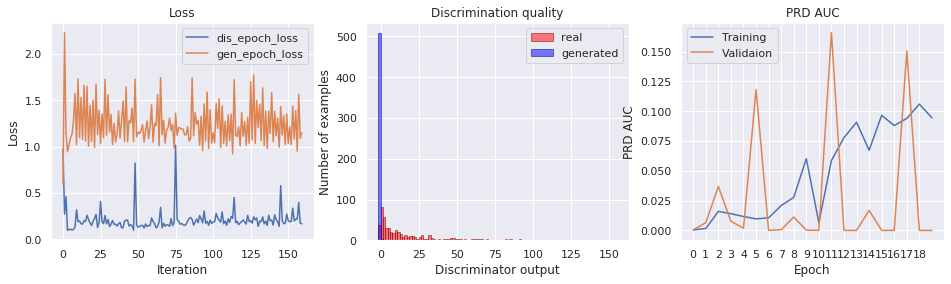

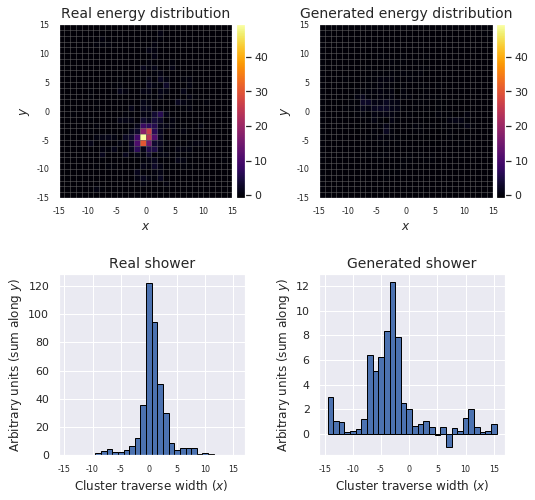

100%|██████████| 20/20 [1:42:46<00:00, 482.49s/it]


The model is saved to /gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/gan_1.pt


In [27]:
dis_model_1, gen_model_1 = train_model(20, 11.)
save_generator(gen_model_1, 'gan_1.pt')

Epoch #19
Mean discriminator output on real data = 15.8017
Mean discriminator output on generated data = -0.974758


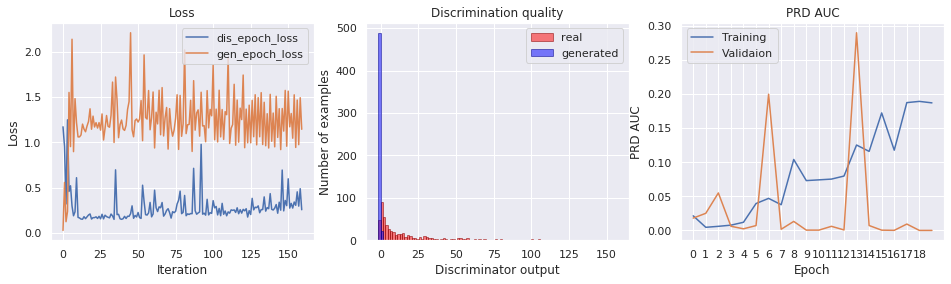

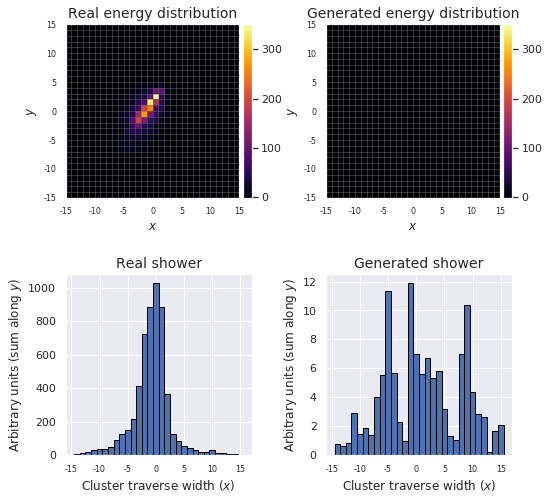

100%|██████████| 20/20 [1:42:33<00:00, 479.04s/it]

The model is saved to /gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/gan_2.pt


In [28]:
dis_model_2, gen_model_2 = train_model(20, 22.)
save_generator(gen_model_2, 'gan_2.pt')

## Combining models for both particle types

Since we have just 2 types of particles, instead of adding embeddings or other layers to take PDG into account, we will just train 2 separate generator and discriminator models, and combine them, on each input choosing the output of the model that was trained on the respective particle type.


In [0]:
# https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/2

class EnsembleGenerator(nn.Module):
    def __init__(self, modelA, modelB):
        super(EnsembleGenerator, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, noise, batch, pdg_arr):
        x1 = self.modelA(noise, batch)
        x2 = self.modelB(noise, batch)
        output = torch.zeros_like(x1)

        for i in range(len(pdg_arr)):
            if pdg_arr[i] == 11.:
                output[i] = x1[i]
            else: # (pdg_arr[i] == 22.)
                output[i] = x2[i]

        return output

# it is not optimal, since some of the generated examples are not used
# but it will do for the moment

ensemble = EnsembleGenerator(gen_model_1, gen_model_2)
ensemble = ensemble.to(device)


Particle ID both
Max train dataset size 50250
Training dataset size = 8000
Validation dataset size = 800
['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']



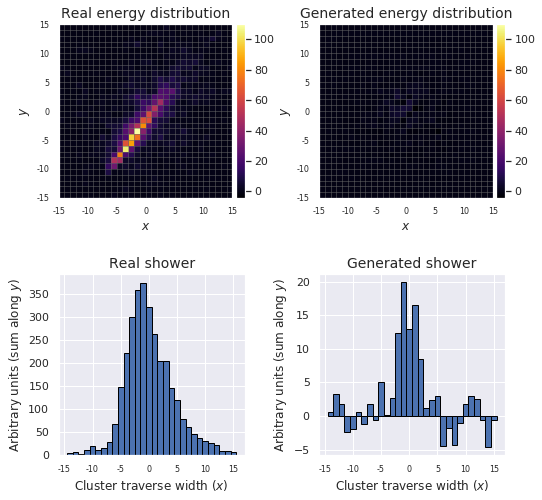

In [0]:
# Testing ensemble

def test_ensemble():
    train_size = 4000*2
    valid_ratio = 0.1
    batch_size = 512

    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    valid_size = int(valid_ratio * train_size)

    train_dataset = get_dataset(data_train, train_size, one_particle_transf=False)
    valid_dataset = get_dataset(data_train, valid_size, one_particle_transf=False)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, 
                                    pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, 
                                    pin_memory=True, shuffle=False)

    res_train_size, res_valid_size = len(train_dataset), len(valid_dataset)

    print()
    print('Particle ID', 'both')
    print('Max train dataset size', MAX_TRAIN_SIZE)
    print('Training dataset size =', res_train_size)
    print('Validation dataset size =', res_valid_size)
    print(list(data_train.keys()))
    print()

    for energy_b, mom_b, point_b, pdg_b in valid_dataloader:
        energy_b, mom_b = energy_b.to(device), mom_b.to(device)
        point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
        mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

        noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
        energy_gen = ensemble(noise, mom_point_b, pdg_b)
        
        plot_energy_and_shower(energy_b.detach().cpu()[0], 
                            energy_gen.detach().cpu()[0])
        break

test_ensemble()

## Making predictions

In [26]:
# Transfer generator on CPU:

# save the last model
#best_generator = generator

save_generator(gen_model_1, 'gan_1.pt')
save_generator(gen_model_2, 'gan_2.pt')

The model is saved to /gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/gan_1.pt
The model is saved to /gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/gan_2.pt


In [0]:
def model_prediction(input_file, output_file, generator_cpu, batch_size=1024, shuffle=False):
    """
    Model test/validation

        Parameters
        ----------
            input_file : str
                Input file name with path (e.g. data/data_val.npz).
            
            output_file : str
                Output file name with path (e.g. output/data_val_prediction.npz).
            
            generator_cpu :
                The generator class.
            
            batch_size : int, optional
                Number of elements in a dataloader batch.
            
            shuffle : bool, optional
                If to enable shuffling in batches.

        Returns:
        ----------
            None
    """
    
    dataset = np.load(input_file, allow_pickle=True)
    val_data_path_out = output_file

    part_mom_val   = torch.tensor(dataset['ParticleMomentum']).float()
    part_point_val = torch.tensor(dataset['ParticlePoint'][:, :2]).float()
    part_mom_point = torch.cat([part_mom_val, part_point_val], dim=1)
    
    calo_dataset    = utils.TensorDataset(part_mom_point)
    calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=batch_size, shuffle=shuffle)

    with torch.no_grad():
        EnergyDeposit_val = []

        for part_mom_point_batch in tqdm(calo_dataloader):
            noise = torch.randn(len(part_mom_point_batch[0]), NOISE_DIM)
            EnergyDeposit_val_batch = generator_cpu(noise, part_mom_point_batch[0]).detach().numpy()
            EnergyDeposit_val.append(EnergyDeposit_val_batch)
        
        np.savez_compressed(output_file, 
                            EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0).reshape(-1, 30, 30))

        del EnergyDeposit_val
    del dataset; del part_mom_val; del part_point_val; del part_mom_point;
    del calo_dataset; calo_dataloader
    return

In [0]:
# (the results are saved to gdrive)

'''
# Validation
model_prediction(def_colab_path + 'data/data_val.npz' , 
                 def_colab_path + 'output/data_val_prediction.npz', 
                 generator_cpu)
# Test
model_prediction(def_colab_path + 'data/data_test.npz', 
                 def_colab_path + 'output/data_test_prediction.npz', 
                 generator_cpu)
'''
# !zip solution.zip data_val_prediction.npz data_test_prediction.npz
# from IPython.display import FileLink
# FileLink('./solution.zip')

## Backup

In [0]:
class ModelD_upsample(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        
        self.main = nn.Sequential(
            # 1 x 30 x 30
            nn.Conv2d(1, NUM_DIS_FEAT, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # NUM_DIS_FEAT x 15 x 15
            nn.Conv2d(NUM_DIS_FEAT, NUM_DIS_FEAT * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NUM_DIS_FEAT * 2),
            nn.LeakyReLU(0.2, inplace=True),


            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = (EnergyDeposit - MEAN_TRAIN_ENERGY_DIST) / STD_TRAIN_ENERGY_DIST
        
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        X = torch.cat([X, mom_point], dim=1)
        
        X = F.leaky_relu(self.fcbn1(self.fc1(X)))
        X = F.leaky_relu(self.fcbn2(self.fc2(X)))
        X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK == 'WASSERSTEIN':
            return self.fc4(X)
        else:
            return torch.sigmoid(self.fc4(X))

class ModelD_oldold(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        
        # 30x30x1
        self.conv1 = nn.Conv2d( 1,   32, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # 30x30x32
        self.ln1   = nn.LayerNorm([32, 30, 30])
        self.conv2 = nn.Conv2d( 32,  64, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # 30x30x64
        self.ln2   = nn.LayerNorm([64, 30, 30])        
        self.pool1 = nn.MaxPool2d(2, 2)                                                  # 15x15x64

        self.conv3 = nn.Conv2d( 64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # 15x15x128
        self.ln3   = nn.LayerNorm([128, 15, 15])
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # 15x15x256
        self.ln4   = nn.LayerNorm([256, 15, 15])
        self.pool2 = nn.MaxPool2d(3, 3)                                                  # 15x15x256
        
        # 5x5x256 = 6400
        self.fc1 = nn.Linear(6400 + 5, 1024, bias=False) 
        self.fcbn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 256, bias=False)
        self.fcbn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 16, bias=False) 
        self.fcbn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = (EnergyDeposit - MEAN_TRAIN_ENERGY_DIST) / STD_TRAIN_ENERGY_DIST
        #X = EnergyDeposit
        
        X = F.leaky_relu((self.conv1(X))) #self.ln1
        X = F.leaky_relu((self.conv2(X)))
        X = self.pool1(X)

        X = F.leaky_relu((self.conv3(X)))
        X = F.leaky_relu((self.conv4(X)))
        X = self.pool2(X)
        
        X = X.view(len(X), -1)
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        X = torch.cat([X, mom_point], dim=1)
        
        X = F.leaky_relu(self.fcbn1(self.fc1(X)))
        X = F.leaky_relu(self.fcbn2(self.fc2(X)))
        X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK == 'WASSERSTEIN':
            return self.fc4(X)
        else:
            return torch.sigmoid(self.fc4(X))

class ModelGConvTranspose_orig(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + 2 + 3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 20736)

        self.conv1 = nn.ConvTranspose2d(256, 256, 3, stride=2, output_padding=1)
        #self.ln1 = nn.LayerNorm([256, 20, 20])
        self.conv2 = nn.ConvTranspose2d(256, 128, 3)
        #self.ln2 = nn.LayerNorm([128, 22, 22])
        self.conv3 = nn.ConvTranspose2d(128, 64, 3)
        #self.ln3 = nn.LayerNorm([64, 24, 24])
        self.conv4 = nn.ConvTranspose2d(64, 32, 3)
        #self.ln4 = nn.LayerNorm([32, 26, 26])
        self.conv5 = nn.ConvTranspose2d(32, 16, 3)
        #self.ln5 = nn.LayerNorm([16, 28, 28])
        self.conv6 = nn.ConvTranspose2d(16, 1, 3)
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #mom_point = ParticleMomentum_ParticlePoint
        x = torch.cat([z, mom_point], dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        EnergyDeposit = x.view(-1, 256, 9, 9)
        
        #print(EnergyDeposit.shape)
        EnergyDeposit = F.leaky_relu((self.conv1(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu((self.conv2(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu((self.conv3(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu((self.conv4(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu((self.conv5(EnergyDeposit)))
        EnergyDeposit = self.conv6(EnergyDeposit)

        return EnergyDeposit

NUM_GEN_FEAT = 128

class ModelGConvTranspose_new(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()

        self.main = nn.Sequential(
            # 15x1x1
            nn.ConvTranspose2d(self.z_dim+2+3,   NUM_GEN_FEAT * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NUM_GEN_FEAT * 8),
            nn.ReLU(True),
            # NUM_GEN_FEAT*8 x4x4           
            nn.ConvTranspose2d(NUM_GEN_FEAT * 8, NUM_GEN_FEAT * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NUM_GEN_FEAT * 4),
            nn.ReLU(True),
            # NUM_GEN_FEAT*4 x8x8
            nn.ConvTranspose2d(NUM_GEN_FEAT * 4, NUM_GEN_FEAT * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NUM_GEN_FEAT * 2),
            nn.ReLU(True),
            # NUM_GEN_FEAT*2 x16x16,
            nn.ConvTranspose2d(NUM_GEN_FEAT * 2, NUM_GEN_FEAT * 1, 4, 2, 2, bias=False),
            nn.BatchNorm2d(NUM_GEN_FEAT * 1),
            nn.ReLU(True),
            # NUM_GEN_FEAT*1 x30x30
            nn.ConvTranspose2d(NUM_GEN_FEAT * 1, 1, 3, 1, 1, bias=False),
            nn.Tanh()
            # 1x30x30
        )

    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #mom_point = ParticleMomentum_ParticlePoint
        x = torch.cat([z, mom_point], dim=1).view(-1, 15, 1, 1)
        
        EnergyDeposit = self.main(x)
        return EnergyDeposit


class ModelGConvTranspose_trying_stuff(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        
        # (self.z_dim+2+3) x 1 x 1
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=5)
        # (self.z_dim+2+3) x 5 x 5
        self.conv1 = nn.Conv2d(self.z_dim+2+3, 10, kernel_size=3, stride=1, padding=1)
        # 10 x 5 x 5
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=3)
        # 10 x 15 x 15
        self.conv2 = nn.Conv2d(10, 5, kernel_size=3, stride=1, padding=1)
        # 5  x 15 x 15
        self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2)
        # 5  x 30 x 30
        self.conv3 = nn.Conv2d(5, 1, kernel_size=3, stride=1, padding=1)
        # 1  x 30 x 30
      
    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #mom_point = ParticleMomentum_ParticlePoint
        x = torch.cat([z, mom_point], dim=1).view(-1, 15, 1, 1)
        
        #print(x.shape)
        x =  F.relu(self.conv1(self.upsample1(x)))
        x =  F.relu(self.conv2(self.upsample2(x)))
        x =  F.relu(self.conv3(self.upsample3(x)))

        EnergyDeposit = x
        
        return EnergyDeposit

SyntaxError: ignored